Epoch [1/50], Train Loss: 8.5157, Val Loss: 8.4971
Epoch [2/50], Train Loss: 7.1187, Val Loss: 7.2392
Epoch [3/50], Train Loss: 5.8877, Val Loss: 6.0637
Epoch [4/50], Train Loss: 4.7829, Val Loss: 4.9105
Epoch [5/50], Train Loss: 3.7448, Val Loss: 3.8129
Epoch [6/50], Train Loss: 2.7856, Val Loss: 2.8340
Epoch [7/50], Train Loss: 1.9852, Val Loss: 1.9573
Epoch [8/50], Train Loss: 1.3233, Val Loss: 1.2956
Epoch [9/50], Train Loss: 0.8483, Val Loss: 0.8352
Epoch [10/50], Train Loss: 0.5426, Val Loss: 0.5296
Epoch [11/50], Train Loss: 0.3524, Val Loss: 0.3557
Epoch [12/50], Train Loss: 0.2477, Val Loss: 0.2602
Epoch [13/50], Train Loss: 0.1936, Val Loss: 0.2007
Epoch [14/50], Train Loss: 0.1612, Val Loss: 0.1697
Epoch [15/50], Train Loss: 0.1428, Val Loss: 0.1515
Epoch [16/50], Train Loss: 0.1301, Val Loss: 0.1376
Epoch [17/50], Train Loss: 0.1202, Val Loss: 0.1280
Epoch [18/50], Train Loss: 0.1119, Val Loss: 0.1191
Epoch [19/50], Train Loss: 0.1043, Val Loss: 0.1117
Epoch [20/50], Train 

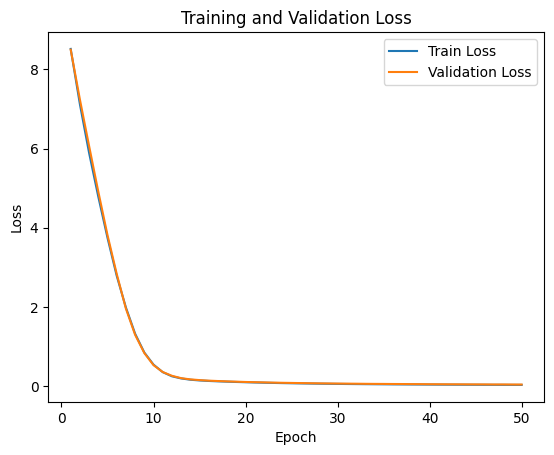

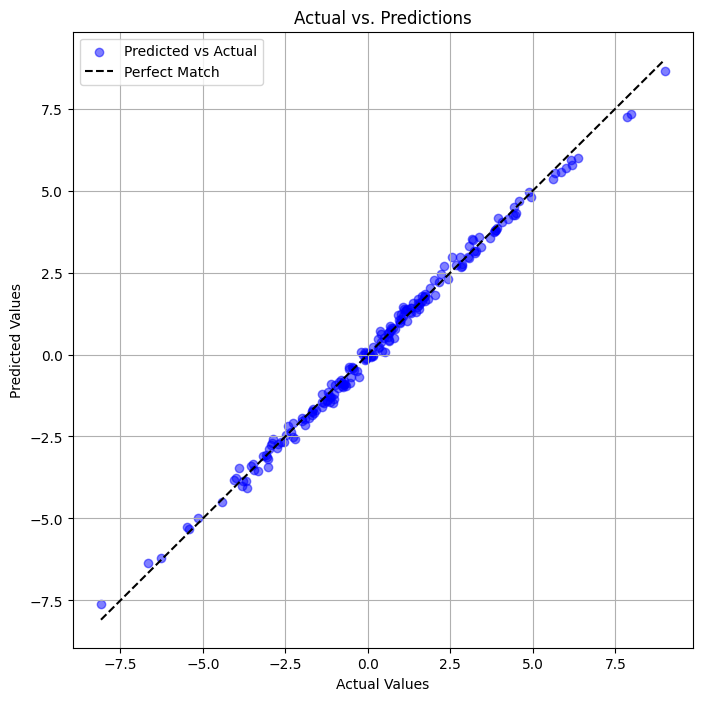

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# サンプルデータの作成 (明確な関係性を持たせる)
def create_sample_data(seed=42):
    torch.manual_seed(seed)
    X = torch.randn(1000, 10)  # 1000サンプル、10次元の特徴量
    true_weights = torch.randn(10, 1)  # 真の重み
    y = X @ true_weights + torch.randn(1000, 1) * 0.1  # 線形関係 + ノイズ
    return X, y, true_weights


# モデル定義
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        # Xavier初期化
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x)


# 学習関数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # バリデーション
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # エポックごとの損失を表示
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


# サンプルデータの作成
X, y, true_weights = create_sample_data()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# ハイパーパラメータ
input_dim = 10
hidden_dim = 32
output_dim = 1
learning_rate = 0.001
batch_size = 32
num_epochs = 50

# モデル、ロス関数、最適化関数の設定
model = SimpleNet(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# データローダー
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# GPUが利用可能であれば使用
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# 学習
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# 学習曲線の可視化
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# バリデーションデータで予測
model.eval()
with torch.no_grad():
    X_val_tensor, y_val_tensor = val_dataset[:]
    X_val_tensor, y_val_tensor = X_val_tensor.to(
        device), y_val_tensor.to(device)
    predictions = model(X_val_tensor).cpu().numpy()

# 実際の値と予測値をプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_val_tensor.cpu().numpy(), predictions,
            color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([y_val_tensor.min().cpu().numpy(), y_val_tensor.max().cpu().numpy()],
         [y_val_tensor.min().cpu().numpy(), y_val_tensor.max().cpu().numpy()], 'k--', label='Perfect Match')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predictions')
plt.legend()
plt.grid(True)
plt.show()

[I 2024-12-03 16:50:33,068] A new study created in memory with name: no-name-b362d4a0-9256-4839-ae62-36894d39e3c1
[I 2024-12-03 16:50:33,307] Trial 0 finished with value: 3.987886071205139 and parameters: {'hidden_dim': 115, 'learning_rate': 0.0005368979492780822, 'batch_size': 128}. Best is trial 0 with value: 3.987886071205139.
[I 2024-12-03 16:50:33,643] Trial 1 finished with value: 0.01639595371671021 and parameters: {'hidden_dim': 116, 'learning_rate': 0.009815600108540852, 'batch_size': 64}. Best is trial 1 with value: 0.01639595371671021.
[I 2024-12-03 16:50:33,970] Trial 2 finished with value: 8.923204779624939 and parameters: {'hidden_dim': 82, 'learning_rate': 1.6499482382741013e-05, 'batch_size': 64}. Best is trial 1 with value: 0.01639595371671021.
[I 2024-12-03 16:50:34,526] Trial 3 finished with value: 7.0492087091718405 and parameters: {'hidden_dim': 78, 'learning_rate': 7.45804940647126e-05, 'batch_size': 32}. Best is trial 1 with value: 0.01639595371671021.
[I 2024-12-

Best trial:
  Value:  0.012821516201186638
  Params: 
    hidden_dim: 103
    learning_rate: 0.008493117752709662
    batch_size: 16
Epoch [1/50], Train Loss: 1.2374, Val Loss: 0.0789
Epoch [2/50], Train Loss: 0.0437, Val Loss: 0.0387
Epoch [3/50], Train Loss: 0.0255, Val Loss: 0.0266
Epoch [4/50], Train Loss: 0.0193, Val Loss: 0.0220
Epoch [5/50], Train Loss: 0.0168, Val Loss: 0.0190
Epoch [6/50], Train Loss: 0.0148, Val Loss: 0.0215
Epoch [7/50], Train Loss: 0.0134, Val Loss: 0.0162
Epoch [8/50], Train Loss: 0.0128, Val Loss: 0.0186
Epoch [9/50], Train Loss: 0.0135, Val Loss: 0.0203
Epoch [10/50], Train Loss: 0.0122, Val Loss: 0.0158
Epoch [11/50], Train Loss: 0.0117, Val Loss: 0.0185
Epoch [12/50], Train Loss: 0.0103, Val Loss: 0.0150
Epoch [13/50], Train Loss: 0.0109, Val Loss: 0.0179
Epoch [14/50], Train Loss: 0.0130, Val Loss: 0.0164
Epoch [15/50], Train Loss: 0.0111, Val Loss: 0.0164
Epoch [16/50], Train Loss: 0.0128, Val Loss: 0.0265
Epoch [17/50], Train Loss: 0.0154, Val Loss:

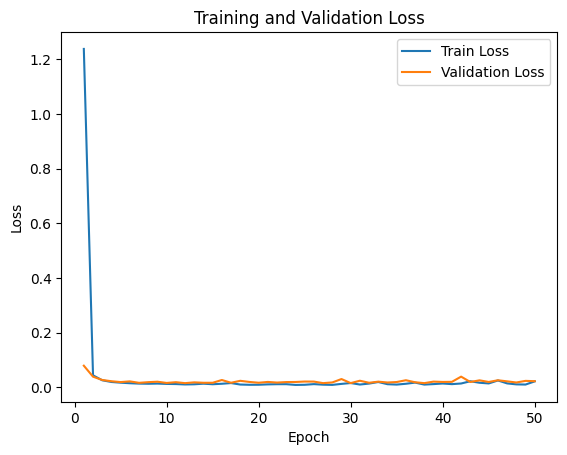

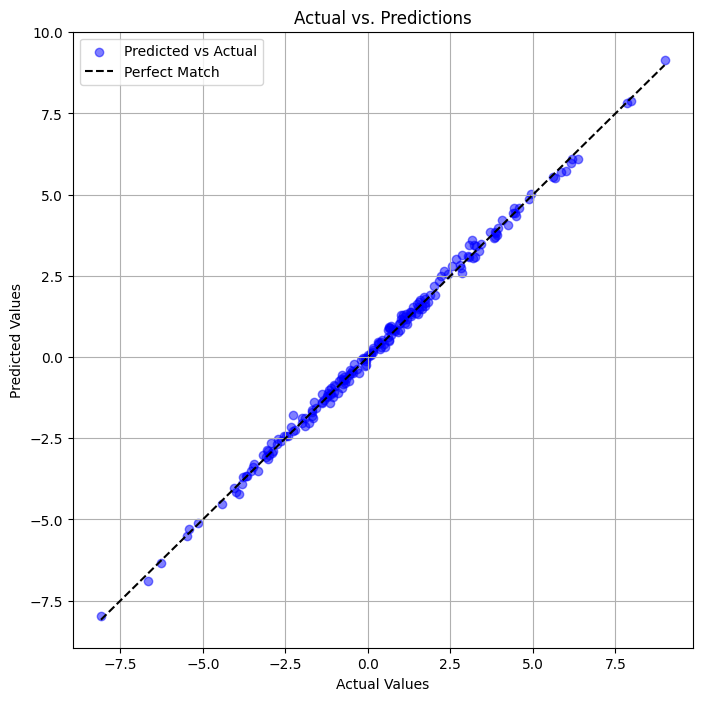

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import optuna


# 目的関数（最小化したい値、ここではバリデーションロス）の定義
def objective(trial):
    # ハイパーパラメータの探索範囲
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # モデル、ロス関数、最適化関数の設定
    model = SimpleNet(input_dim, hidden_dim, output_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # データローダー (train_dataset, val_datasetは前のコードセルで定義)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # 学習 (エポック数は少なく設定)
    num_epochs = 10
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # バリデーション
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()
        val_loss /= len(val_loader)

        # best_val_lossの更新とpruning判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        trial.report(val_loss, epoch)  # 各epochのlossを報告

        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_loss


def optimize_hyperparameters(n_trials=30):
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(), direction='minimize')  # MedianPrunerを追加
    study.optimize(objective, n_trials=n_trials)

    print('Best trial:')
    trial = study.best_trial
    print('  Value: ', trial.value)
    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

    return trial.params


# ベイズ最適化の実行
best_params = optimize_hyperparameters(n_trials=50)

# 最適パラメータで再学習
model = SimpleNet(input_dim, best_params["hidden_dim"], output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
train_loader = DataLoader(
    train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(
    val_dataset, batch_size=best_params['batch_size'], shuffle=False)

final_train_losses, final_val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, 50, device)  # train_model関数は前のコードから流用


# 学習曲線の可視化
plt.plot(range(1, num_epochs+1), final_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), final_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# バリデーションデータで予測
model.eval()
with torch.no_grad():
    X_val_tensor, y_val_tensor = val_dataset[:]
    X_val_tensor, y_val_tensor = X_val_tensor.to(
        device), y_val_tensor.to(device)
    predictions = model(X_val_tensor).cpu().numpy()

# 実際の値と予測値をプロット
plt.figure(figsize=(8, 8))
plt.scatter(y_val_tensor.cpu().numpy(), predictions,
            color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([y_val_tensor.min().cpu().numpy(), y_val_tensor.max().cpu().numpy()],
         [y_val_tensor.min().cpu().numpy(), y_val_tensor.max().cpu().numpy()], 'k--', label='Perfect Match')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predictions')
plt.legend()
plt.grid(True)
plt.show()